# Autocorrelation

In [1]:
import zipfile
import pandas as pd
import numpy as np
from datetime import datetime

# bokeh libraries
import matplotlib.pyplot as plt
import seaborn as sns

#set rendering to notebook
#output_notebook()

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


When we talk about autocorrelation, we are talking about the correlation of a time series with a lagged version of itself. In general, the formula for the autocorrelation at lag $k$ is

$$
r_k = \frac{\Sigma_{i=1}^{n-k}(X_i - \bar{X})(X_{i+k} - \bar{X})}{\Sigma_{i=1}^{n}(X_i - \bar{X})^2}
$$

Suppose we have a *very small* timeseries, of only two values: $[3,2]$. Note that in this case $\bar{X} = 5/2 = 2.5$, and that the variance (the denominator of the equation above) is $(3-2.5)^2 + (5-2.5)^2 = 0.5^2+(−0.5)^2=0.25+0.25=0.5$. 

The autocorrelation for lag 0 is always one, as a series correlates perfectly with itself:

$$
r_0 = \frac{\Sigma(X_i - \bar{X})^2}{\Sigma(X_i - \bar{X})^2} = 1
$$


For lag 1, we take the first value again ($X_1=3$) and compare that with the second value ($X_2 = 2$):

$$
r_1 = \frac{(3 - 2.5)(2 - 2.5)}{0.5} 
= \frac{(0.5)(-0.5)}{0.5} = \frac{0.25}{0.5} = -0.5
$$

There are no more lags, so this will be our whole autocorrelation. Let's see this in code – to get the numeral values we are using [`statsmodels.tsa.stattools.acf`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html), which we already imported in the first cell. Later, we will just plot these values using [`statsmodels.graphics.tsaplots.plot_acf`](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html) and [`statsmodels.graphics.tsaplots.plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html).

In [2]:
X = [3,2]
acf(X)

array([ 1. , -0.5])

As you see, we were note lying when we stated that the results of this very small dataset would be $(1, -0.5)$. Now, let's see how this statistic is used in a more real-world scenario.

## A more real-world scenario

In [3]:
# Original data comes from the site below. You can download it there and put it in you data-directory. Or try 
# to load it in one flow, but odds are you'll get an SSL-error.
#path = "https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/daggegevens/etmgeg_260.zip"
#df = pd.read_csv(path,compression='zip', skiprows=51, low_memory=False)

df = pd.read_csv('../data/etmgeg_260.txt', skiprows=51, low_memory=False)
df.columns = df.columns.str.strip()
df.head()

,# STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,260,19010101,,,,,,,,,...,,,,,66,,,,,
1,260,19010102,,,,,,,,,...,,,,,86,,,,,
2,260,19010103,,,,,,,,,...,,,,,89,,,,,
3,260,19010104,,,,,,,,,...,,,,,79,,,,,
4,260,19010105,,,,,,,,,...,,,,,65,,,,,


In [4]:
def preprocess(df):
    """
    preprocess 'de bilt etmaalgegevens' for analysis
    
    parameters: raw dataframe
    returns: cleaned dataframe
    
    """
    #FG = Etmaalgemiddelde windsnelheid (in 0.1 m/s) 
    #TG = Etmaalgemiddelde temperatuur (in 0.1 graden Celsius) 
    #YYYYMMDD = timestamp
    
    threshold_value = -6.5  

    df = df.rename(columns={"YYYYMMDD": "date", "TG": "temperature", "FG": "velocity"}, 
              errors="raise")
    df = df[['date', 'temperature', 'velocity']]
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
    df['temperature'] = df['temperature'].astype('float64')
    df['velocity'] = pd.to_numeric(df['velocity'], errors='coerce')
    df.temperature = df.temperature/10
    df.velocity = df.velocity/10
   
    df.set_index('date', inplace=True)     
    return df

In [5]:
df = preprocess(df)
plt.style.use('dark_background')
subset = df['2020':'2024']


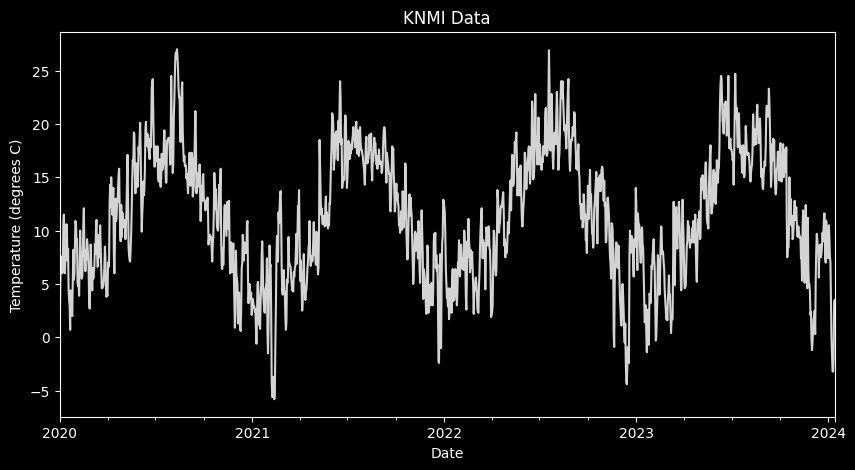

In [6]:
# Plot the temperature data
fig, ax = plt.subplots(figsize=(10, 5))
subset['temperature'].plot(color='lightgrey', ax=ax)

# Set title and labels
ax.set_title("KNMI Data")
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (degrees C)')

# Display the plot


plt.show()

We can calculate how much the temperature of a day is related to the temparature of the day before that day. 

In [7]:
temperature_day = subset['temperature'][1:]
temperature_day_minus_shift = subset['temperature'][:-1]
print(temperature_day[0:3])
print(temperature_day_minus_shift[0:3])



date
2020-01-02    3.9
2020-01-03    7.6
2020-01-04    6.7
Name: temperature, dtype: float64
date
2020-01-01    0.8
2020-01-02    3.9
2020-01-03    7.6
Name: temperature, dtype: float64


date
2020-01-11    6.0
Name: temperature, dtype: float64
date
2020-01-01    0.8
Name: temperature, dtype: float64
The correlation between temperature_day and temperature_day_minus_shift is:
[[1.         0.71391081]
 [0.71391081 1.        ]]


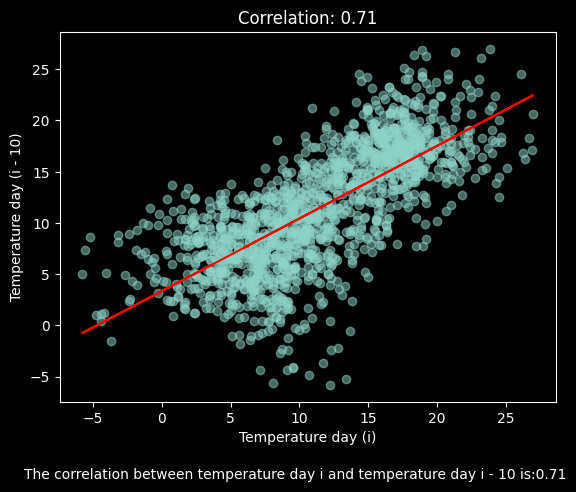

In [8]:
shift = 10
temperature_day = subset['temperature'][shift:]
temperature_day_minus_shift = subset['temperature'][:-shift]
print(temperature_day[0:1])
print(temperature_day_minus_shift[0:1])

# Calculate the correlation
corr = np.corrcoef(temperature_day, temperature_day_minus_shift)
print('The correlation between temperature_day and temperature_day_minus_shift is:')
print(corr)

# Scatter plot
plt.scatter(temperature_day, temperature_day_minus_shift, alpha=0.5)

# Add a red trend line
m, b = np.polyfit(temperature_day, temperature_day_minus_shift, 1)  # Linear fit
plt.plot(temperature_day, m*temperature_day + b, color='red')
# Labels and title
plt.xlabel('Temperature day (i)')
plt.ylabel(f'Temperature day (i - {shift})')
plt.title(f'Correlation: {corr[0, 1]:.2f}')

# Add a text annotation below the plot
plt.text(-10, -15,
         f'The correlation between temperature day i and temperature day i - {shift} is:{corr[0, 1]:.2f}',
         wrap=False, fontsize=10, color='white')

plt.show()

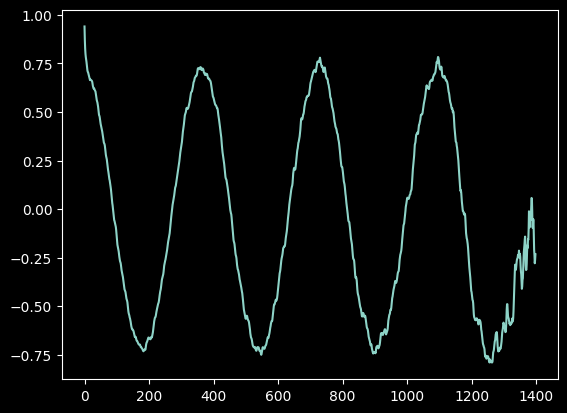

In [9]:
# Do this for multiple shifts 
autocorr = []
for shift in range(1, 1400):  
    temperature_day = subset['temperature'][shift:]
    temperature_day_minus_shift = subset['temperature'][:-shift]
    corr = np.corrcoef(temperature_day, temperature_day_minus_shift)
    autocorr.append(corr[0, 1])

plt.plot(autocorr)
    

The further away, the lower the correlation. But at some points the temperatures are similar again, since there is a seasonal effect

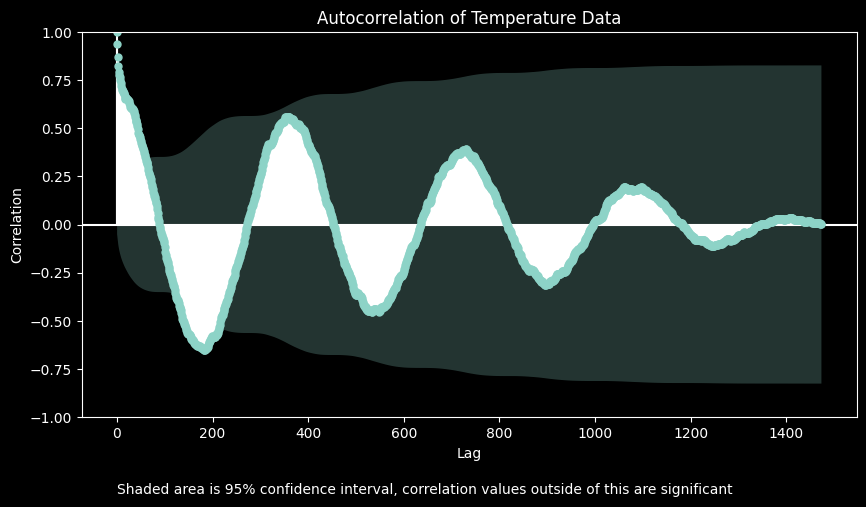

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(subset['temperature'], ax=ax, lags=len(subset['temperature'])-1)
plt.title('Autocorrelation of Temperature Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')

# Add a text annotation below the plot
plt.text(-0.5, -1.4,
         'Shaded area is 95% confidence interval, correlation values outside of this are significant',
         wrap=False, fontsize=10, color='white')

plt.savefig('autocorrelation_weather_largelag.png')
plt.show()

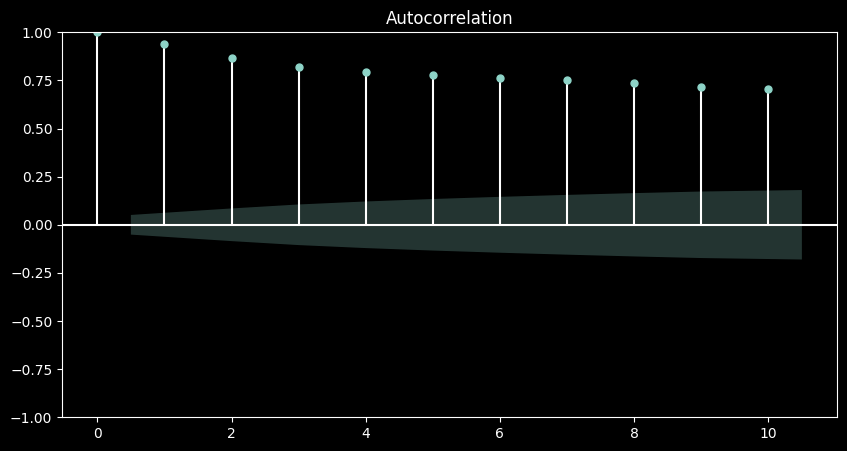

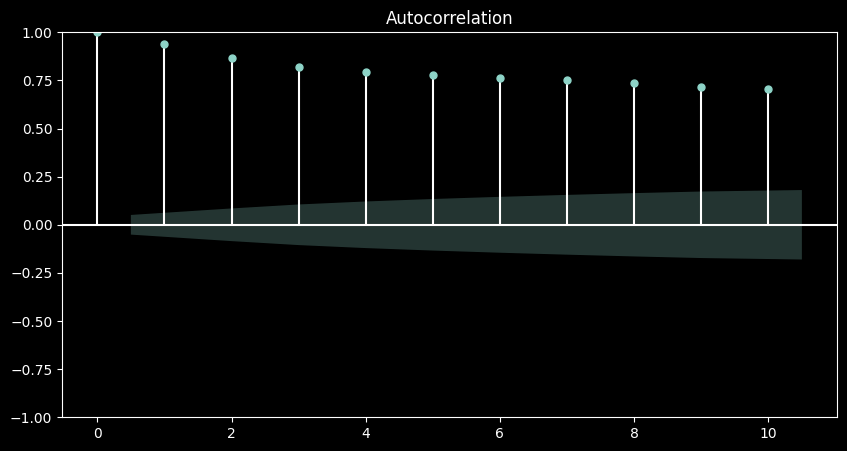

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(subset['temperature'], ax=ax, lags=10)

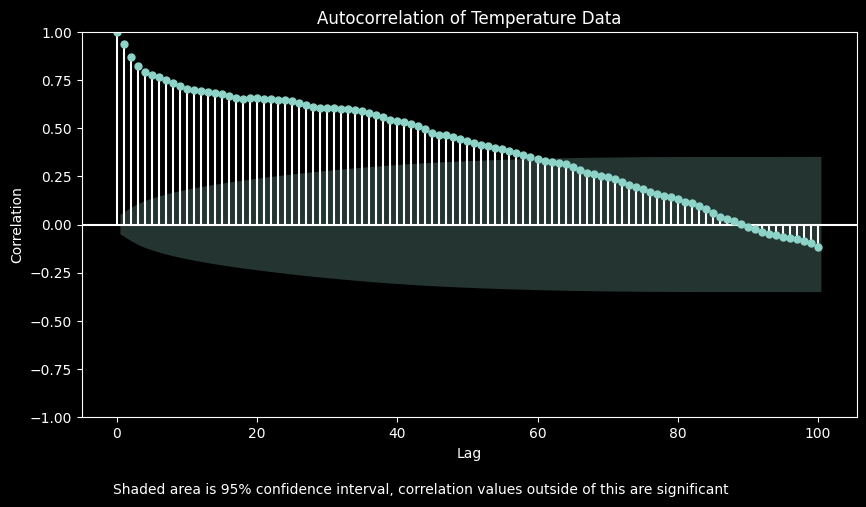

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(subset['temperature'], ax=ax, lags=100)
plt.title('Autocorrelation of Temperature Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')

# Add a text annotation below the plot
plt.text(-0.5, -1.4,
         'Shaded area is 95% confidence interval, correlation values outside of this are significant',
         wrap=False, fontsize=10, color='white')

plt.savefig('autocorrelation_weather_shortlag.png')
plt.show()

# Partial autocorrelation
Partial Autocorrelation (PACF) measures the direct relationship between a time series and its lagged values, while removing the influence of all intermediate lags.

Autocorrelation (ACF) measures the correlation between a time series and a lagged version of itself.

Partial Autocorrelation (PACF) removes the effects of previous lags to show the pure effect of a specific lag.


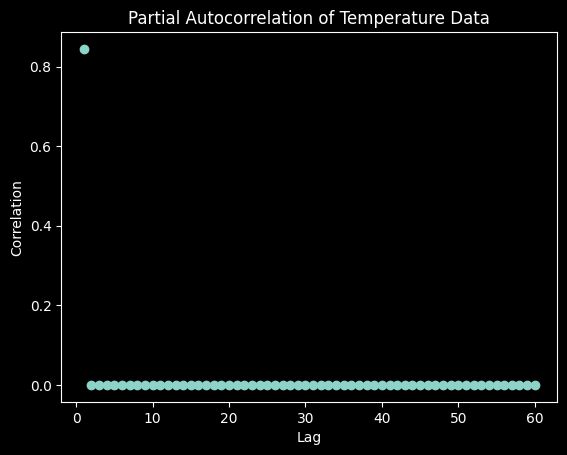

In [13]:
def naive_pacf(series, max_lag):
    pacf = []
    
    for lag in range(1, max_lag + 1):
        # Copy original series
        residuals = series.copy()
        
        # Regress out all lower lags (up to current lag)
        for prev_lag in range(1, lag):
            slope, intercept = np.polyfit(series[:-prev_lag], residuals[prev_lag:], 1)
            estimate = slope * series[:-prev_lag] + intercept
            
            # Subtract estimate to remove effect of previous lags
            residuals[prev_lag:] -= estimate
            
        # Compute final correlation for this lag
        pacf_value = np.corrcoef(series[:-lag], residuals[lag:])[0, 1]
        pacf.append(pacf_value)

    return pacf

# Compute PACF for lags 1 to 10
pacf_values = naive_pacf(temperature_day, 60)
pacf_values = [val if not np.isnan(val) else 0 for val in pacf_values]  # Replace NaN with 0
plt.scatter(x=range(1, len(pacf_values) + 1), y=pacf_values)
plt.title('Partial Autocorrelation of Temperature Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()




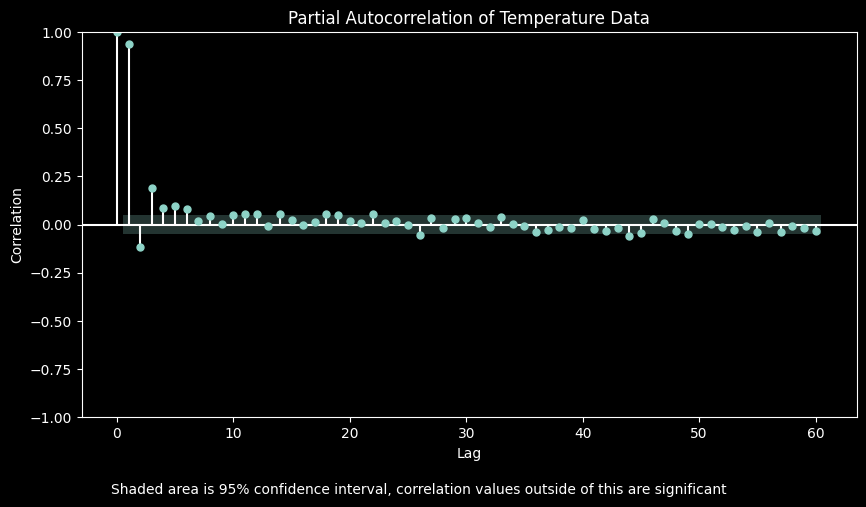

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(subset['temperature'], ax=ax, lags=60)
plt.title('Partial Autocorrelation of Temperature Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')

# Add a text annotation below the plot
plt.text(-0.5, -1.4,
         'Shaded area is 95% confidence interval, correlation values outside of this are significant',
         wrap=False, fontsize=10, color='white')
plt.savefig('partical_autocorrelation_weather_shortlag.png')
plt.show()

In [15]:
k = 20
series = subset['temperature'].rolling(window=k).mean()
series[k:]

date
2020-01-21    6.740
2020-01-22    6.765
2020-01-23    6.570
2020-01-24    6.350
2020-01-25    6.105
              ...  
2024-01-09    7.195
2024-01-10    6.545
2024-01-11    6.000
2024-01-12    5.650
2024-01-13    5.245
Name: temperature, Length: 1454, dtype: float64

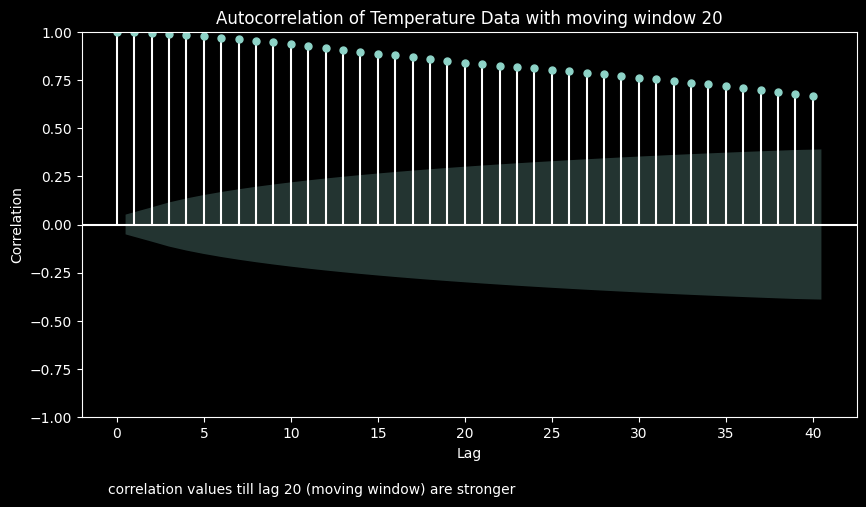

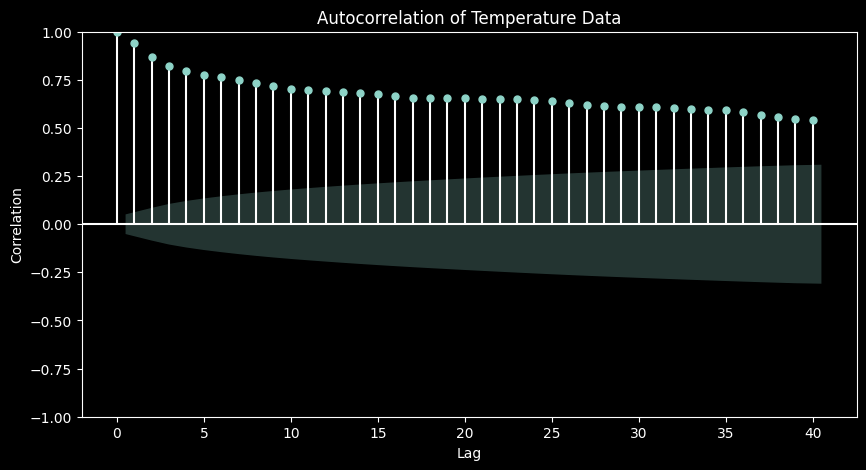

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(series[k:], ax=ax, lags=40)
plt.title(f'Autocorrelation of Temperature Data with moving window {k}')
plt.xlabel('Lag')
plt.ylabel('Correlation')
# Add a text annotation below the plot

plt.text(-0.5, -1.4,
         f'correlation values till lag {k} (moving window) are stronger',
         wrap=False, fontsize=10, color='white')

plt.savefig('autocorrelation_weather_shortlag_rolling40.png')
plt.show()


fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(subset['temperature'], ax=ax, lags=40)
plt.title(f'Autocorrelation of Temperature Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')

plt.savefig('40autocorrelation_weather_shortlag40.png')

plt.show()




In [17]:
import statsmodels.api as sm
result = sm.tsa.seasonal_decompose(subset['temperature'], model='additive')


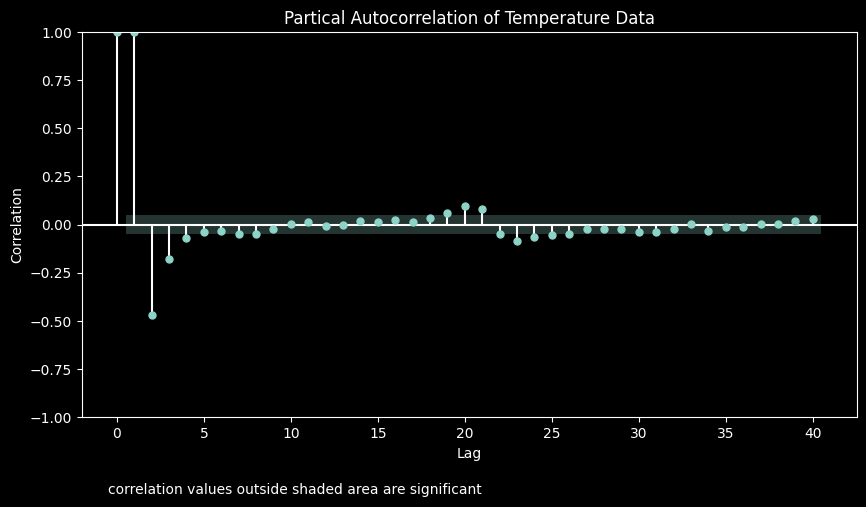

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(series[k:], ax=ax, lags=40)
plt.title('Partical Autocorrelation of Temperature Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.savefig('autocorrelation_weather_shortlag40.png')
# Add a text annotation below the plot

plt.text(-0.5, -1.4,
         f'correlation values outside shaded area are significant',
         wrap=False, fontsize=10, color='white')

plt.savefig('partical_autocorrelation_weather_shortlag_rolling.png')

plt.show()

## Interpretation

__Interpretation of an ACF-plot__

- If there is strong positive autocorrelation at a given lag, it means that values at that point are strongly related to previous values.
- A strong negative autocorrelation indicates that when one value is high, the next tends to be low.
- A rapidly decreasing ACF indicates that the series has little memory, while a slowly decreasing ACF indicates long-term dependencies.

__Interpretation of a PACF-plot__
- Lag 0: Always has a correlation of 1 (since a time series is perfectly correlated with itself)
- A significant PACF at lag $k$ means that there is a direct relationship between $X_t$ and $X_{t−k}$, after correcting for previous lags.
- If the PACF quickly goes to zero, this means that the time series can follow an autoregressive (AR) model.

## One more example

We use the generated ecg-signal from neurokit as one more example.

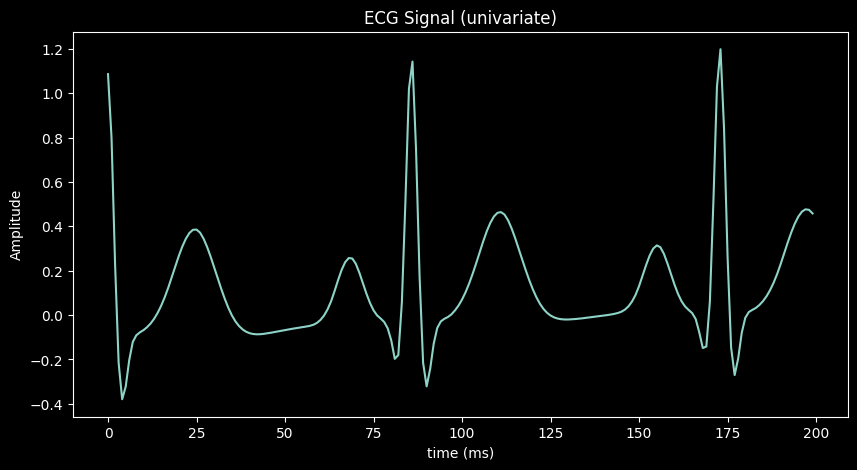

In [19]:
import neurokit2 as nk
import matplotlib.pyplot as plt

# Set the parameters for simulating ECG data
sampling_rate = 100  # Sampling rate in Hz
duration = 10  # Duration of the signal in seconds

# Simulate ECG data
ecg_signal = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate)
# Plot the synthetic ECG signal
plt.figure(figsize=(10, 5))
plt.plot(ecg_signal[:200])
plt.title('ECG Signal (univariate)')
plt.xlabel('time (ms)')
plt.ylabel('Amplitude')
#plt.savefig('ECG.png')
plt.show()

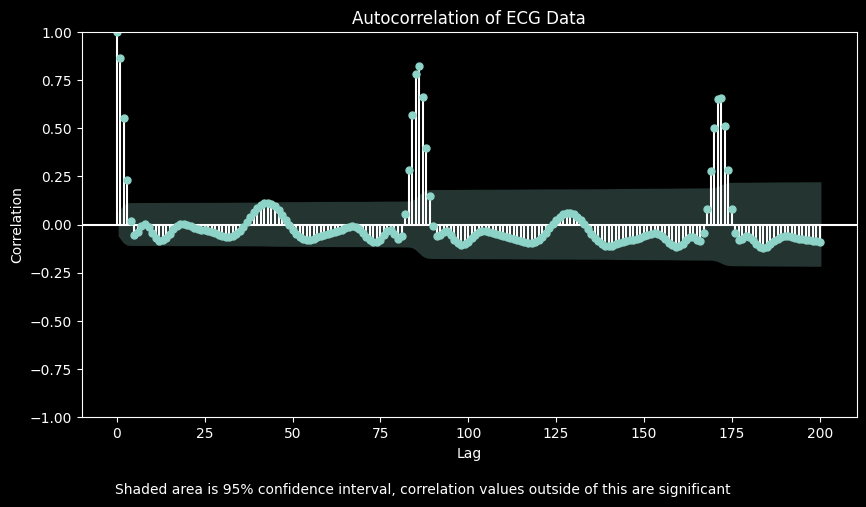

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(ecg_signal, ax=ax, lags=200)
plt.title('Autocorrelation of ECG Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')

# Add a text annotation below the plot
plt.text(-0.5, -1.4,
         'Shaded area is 95% confidence interval, correlation values outside of this are significant',
         wrap=False, fontsize=10, color='white')

plt.savefig('autocorrelation_ecg_largelag.png')
plt.show()

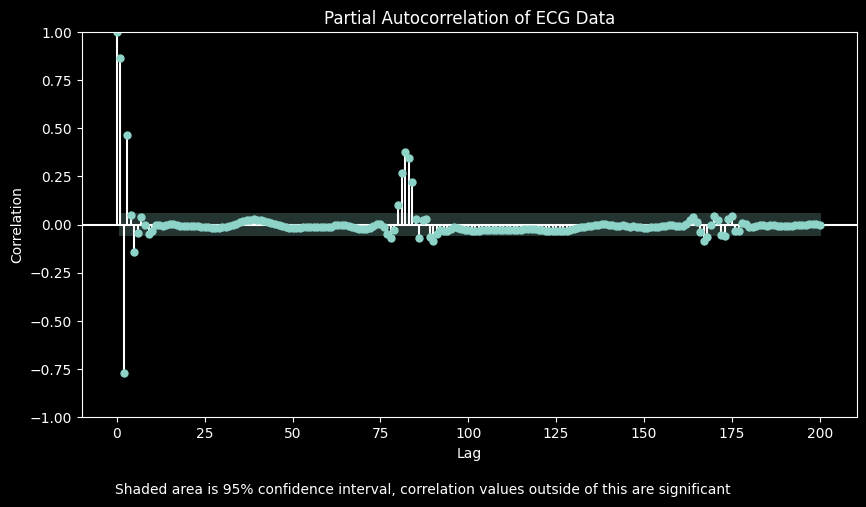

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(ecg_signal, ax=ax, lags=200)
plt.title('Partial Autocorrelation of ECG Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')

# Add a text annotation below the plot
plt.text(-0.5, -1.4,
         'Shaded area is 95% confidence interval, correlation values outside of this are significant',
         wrap=False, fontsize=10, color='white')

plt.savefig('partial_autocorrelation_ecg_largelag.png')
plt.show()

- Lag 0: Always has a correlation of 1 (since a time series is perfectly correlated with itself).
- The first few lags seem to have strong correlations, which is typical for ECG signals because heartbeats are periodic
- around 75 - 100 There’s an increase in correlation, possibly indicating repeating patterns in the ECG waveform.
- If significant autocorrelations persist at high lags, it might indicate arrhythmias or abnormal heart rhythms.
